In [1]:
library(tidyverse)
library(readxl)
library(data.table)
library (ggplot2)
#install.packages("ggpubr")
#library(ggpubr)
#library(clusterProfiler)
#library(org.Hs.eg.db)
#library(biomaRt)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.1”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
Warning message:
“package ‘readr’ was built under R version 4.2.1”
Warning message:
“package ‘stringr’ was built under R version 4.2.2”
Warning message:
“package ‘forcats’ was built under R version 4.2.1”
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘readxl’ was built under R version 4.2.1”
Warning message:
“package ‘data.table’ was built under R version 4.2.2”

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

  

In [2]:
prop_coarse_cells = "/nfs/team205/vk8/scripts/de_lmm_natsuhiko/results_all/DE_human_scell_coarse_v2_2023May_prop_stat.csv"
prop_coarse_nuclei = "/nfs/team205/vk8/scripts/de_lmm_natsuhiko/results_all/DE_human_snuclei_coarse_v2_2023May_prop_stat.csv"
DE_coarse_nuclei = "/nfs/team205/vk8/scripts/de_lmm_natsuhiko/DE_human_snuclei_coarse_v2_2023May/de_celltype_Age_interaction_all.txt"
DE_coarse_cells = "/nfs/team205/vk8/scripts/de_lmm_natsuhiko/DE_human_scell_coarse_v2_2023May/de_celltype_Age_interaction_all.txt"

In [3]:
prop_fine_cells = "/nfs/team205/vk8/scripts/de_lmm_natsuhiko/results_all/DE_human_scell_granular_v2_2023May_prop_stat.csv"
prop_fine_nuclei = "/nfs/team205/vk8/scripts/de_lmm_natsuhiko/results_all/DE_human_snuclei_granular_v2_2023May_prop_stat.csv"
DE_fine_nuclei = "/nfs/team205/vk8/scripts/de_lmm_natsuhiko/DE_human_snuclei_granular_v2_2023May/de_celltype_Age_interaction_all.txt"
DE_fine_cells = "/nfs/team205/vk8/scripts/de_lmm_natsuhiko/DE_human_scell_granular_v2_2023May/de_celltype_Age_interaction_all.txt"

In [19]:
source_files = "/nfs/team205/vk8/scripts/scvi/SKM_ageing_atlas_SourceFiles/"

In [4]:
res_path_cells = "/nfs/team205/vk8/scripts/de_lmm_natsuhiko/results_all"

In [5]:
read_and_process = function(input_de_path, input_prop_path){
    de_dt = fread(input_de_path)
    prop_dt = fread(input_prop_path)
    colnames(de_dt)[2] = "SYMBOL"
    de_dt[, log2fc:=beta_old-beta_young]
#    de_dt[, cell_type_common:=celltype]
    de_dt[, sign:=ltsr>0.9]
    de2prop_dt = merge(de_dt, prop_dt, by.x = c("ENSEMBL", "SYMBOL", "celltype"), by.y = c("ENSEMBL", "SYMBOL", "celltype"))
    de2prop_dt[, REGULATION:=case_when((log2fc>0 & ltsr > 0.9) ~ "UP", (log2fc<0 & ltsr > 0.9) ~ "DW",TRUE ~ 'none')]
    return(de2prop_dt)
}

In [6]:
DE_tb_cells = read_and_process(input_de_path = DE_coarse_cells, 
                               input_prop_path = prop_coarse_cells)
DE_tb_nuclei = read_and_process(input_de_path = DE_coarse_nuclei, 
                               input_prop_path = prop_coarse_nuclei)

DE_genes_broad2entrez = rbind(DE_tb_cells, DE_tb_nuclei)

In [7]:
DE_tb_cells_fine = read_and_process(input_de_path = DE_fine_cells, 
                               input_prop_path = prop_fine_cells)
DE_tb_nuclei_fine = read_and_process(input_de_path = DE_fine_nuclei, 
                               input_prop_path = prop_fine_nuclei)

DE_genes_fine = rbind(DE_tb_cells_fine, DE_tb_nuclei_fine)

In [9]:
mito_biogenesis = c('PPARGC1A', 'NRF1', 'CYRIB','GABPA', 'TFAM', 'TFB1M', 'TFB2M', 'VEGFC') # mitochondrial biogenesis
glycolis = c("HK1", "GPI", "PFKM", "ALDOA", "TPI1", "GAPDH", "PGK1", "PGAM2", "ENO3", "PKM")
glycogenolis = c("AGL", "PYGM", "PHKA1", "PHKB", "EPM2A", "PPP1R3A", "PGM1", "GYG1", "GYS1", "GBE1", "UGP2", "SLC37A4")


In [10]:
myofiber_types = c('MF-I', 'MF-Isn(fg)', 'MF-Isc(fg)', 'MF-II', 'MF-IIsn(fg)', 'MF-IIsc(fg)')

In [11]:
myofiber_types_filt = c('MF-I', 'MF-Isc(fg)', 'MF-II', 'MF-IIsc(fg)')

In [12]:
DE_genes_broad2entrez$REGULATION = factor(DE_genes_broad2entrez$REGULATION, levels = c("none", "UP", "DW"))
DE_genes_broad2entrez$celltype = factor(DE_genes_broad2entrez$celltype, levels = 
      c('MF-I', 'MF-Isn(fg)', 'MF-Isc(fg)', 'MF-II', 'MF-IIsn(fg)', 'MF-IIsc(fg)', 'Hyb', 'MTJ', 'NMJ', 'NMJ_accessory',
       'MuSC', 'FB', 'Tenocyte', 'EnFB', 'PnFB', 'mSchwann', 'nmSchwann', 'Adipocyte', 
       'ArtEC', 'CapEC', 'VenEC', 'Pericyte', 'SMC',
       'CD4+T','CD8+T', 'CD16+NK','CD16-NK', 'B-cell','B-plasma', 
       'CD14+Mono', 'CD16+Mono', 'Macrophage', 'cDC1', 'cDC2', 'Mast', 'Neutrophil'
       ))

In [16]:
gluc_DE = DE_genes_broad2entrez[(SYMBOL %in% c("HK1", "GPI", "PFKM", "ALDOA", "TPI1", "GAPDH",
                                               "PGK1", "PGAM2", "ENO3", "PKM", "SLC37A4", 'PPARGC1A')) & 
                                (celltype %in% myofiber_types_filt)]
#gluc_DE$SYMBOL = factor(gluc_DE$SYMBOL, levels = c(rev(glycogenolis), rev(glycolis)))
gluc_DE$SYMBOL = factor(gluc_DE$SYMBOL, levels = c(glycolis, glycogenolis, "PPARGC1A"))
gluc_DE$celltype = factor(gluc_DE$celltype, c( 'MF-II','MF-IIsc(fg)', 'MF-I', 'MF-Isc(fg)'))

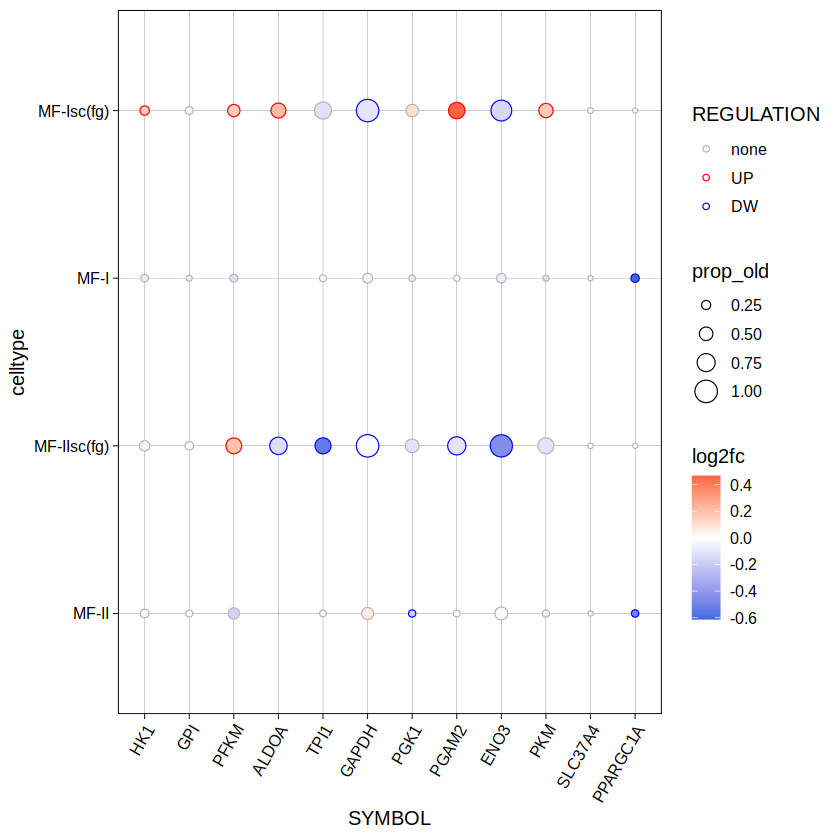

In [17]:
p_gluc = ggplot(gluc_DE, aes(x= SYMBOL, y=celltype, size=prop_old, fill=log2fc, color = REGULATION, 
                             group = celltype)) + 
  geom_point(pch=21) +
  theme_linedraw(base_size = 12) +
  theme(axis.text.x = element_text(angle = 60, hjust=1)) + 
 # scale_fill_gradientn(colors = rev(brewer.pal(11, "RdBu"))) + 
  scale_fill_gradient2(midpoint = 0, low = "royalblue", mid = "white",
                            high = "red", space = "Lab" ) + 
  scale_color_manual(values = c("gray70", "red", "blue")) + 
  scale_radius(limits = range(0.01, 1))
p_gluc
#ggsave(filename = "/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/figures/DE_gluc_mf_broad.pdf", plot = p_gluc, width = 6, height = 3, dpi = 300, useDingbats = FALSE)  

In [20]:
source_files

[1] "/nfs/team205/vk8/scripts/scvi/SKM_ageing_atlas_SourceFiles/"

In [22]:
write.csv(gluc_DE, paste0(source_files, "ExtendedDataFig7b.csv"))